# load float log

In [1]:
import os
from glob import glob
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cognac.float as fl
import cognac.float.seabot as sb

---
## load data

In [67]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/'
#root_dir = root_dir+'bassin0_bags/'
root_dir = root_dir+'bassin1_bags/'

bags = sb.find_bags(root_dir)
logs = sb.find_logs(root_dir)

[print(b) for b in bags]

i = -3
bag = bags[i]
log = logs[i]

bdata = sb.load_bag(bag)
cfg = sb.load_config_from_log(log)

# load config file
#file = root_dir+'config_ifremer1.yaml'
#cfg = load_config(file)

/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-18-07_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-35-39_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-55-40_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-04-14_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-15-25_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-28-29_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-41-36_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-48-45_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-16-14-23_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_20

In [68]:
for b, d in bdata.items():
    print(b, list(d))

regulationHeadingSetPoint ['set_point', 'seconds']
fix ['altitude', 'err', 'err_horz', 'err_speed', 'err_time', 'err_track', 'err_vert', 'gdop', 'hdop', 'latitude', 'longitude', 'pdop', 'speed', 'status', 'tdop', 'seconds', 'track', 'vdop']
pistonState ['enable_on', 'motor_on', 'motor_speed', 'position', 'position_set_point', 'state', 'switch_in', 'switch_out', 'seconds']
poseFusion ['east', 'heading', 'north', 'seconds']
batteryFusion ['b1', 'b2', 'b3', 'b4', 'seconds']
iridiumSession ['mo', 'momsn', 'mt', 'mtmsn', 'seconds', 'waiting']
iridiumStatus ['antenna', 'service', 'signal_strength', 'seconds']
safetyDebug ['flash', 'ratio_delta', 'ratio_p_t', 'seconds', 'volume', 'volume_delta', 'zero_depth']
kalman ['chi', 'chi2', 'cov_chi', 'cov_chi2', 'cov_cz', 'cov_depth', 'cov_offset', 'cov_velocity', 'cz', 'depth', 'offset', 'offset_total', 'seconds', 'valid', 'velocity', 'volume']
safetyCpu ['cpu', 'ram', 'seconds']
regulation ['dy', 'mode', 'set_point', 'seconds', 'u', 'y']
engineCmd 

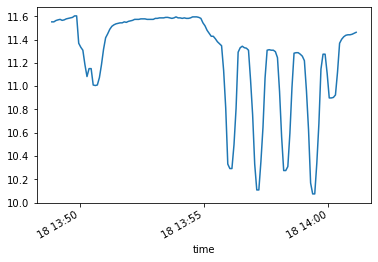

In [69]:
bdata['batteryFusion']['b1'].plot()

In [70]:
_df = sb.resample_join('5s',
                       bdata['batteryFusion']['b1'].rename('battery'),
                       bdata['pistonVelocity']['velocity'],
                       bdata['pistonState']['position']
                      )

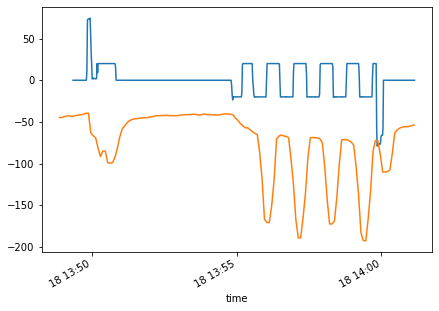

In [71]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
bdata['pistonVelocity']['velocity'].plot(ax=ax)
(bdata['batteryFusion']['b1']*100-1200).rename('battery').plot(ax=ax)
ax

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x11b22e438>>

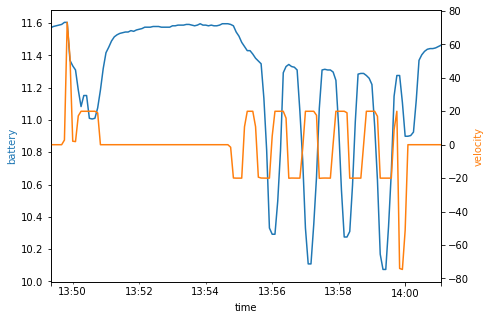

In [72]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

k0 = 'battery'
k1 = 'velocity'

_df[k0].plot(ax=ax, color='C0')
_ax = ax.twinx()
_df[k1].plot(ax=_ax, color='C1')
ax.set_ylabel(k0, color='C0')
_ax.set_ylabel(k1, color='C1')
ax.grid
#ax.legend()
#plt.show()

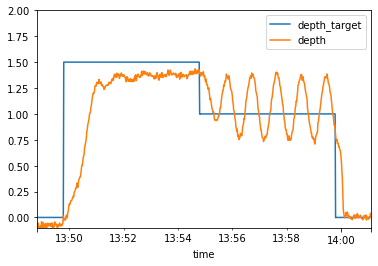

In [73]:
df_gen = sb.resample_join('1s',
                       bdata['mission']['depth'].rename('depth_target'),
                       bdata['depthFusion']['depth']
                      )
_ = df_gen.plot(ylim=(-.1, 2.))

---
## kalman filter

In [4]:
kalman_state = (bdata['kalman'][[c for c in bdata['kalman'].columns if 'cov' not in c]]
                .drop(columns='seconds')
               )
kalman_cov = bdata['kalman'][[c for c in bdata['kalman'].columns if 'cov' in c]]

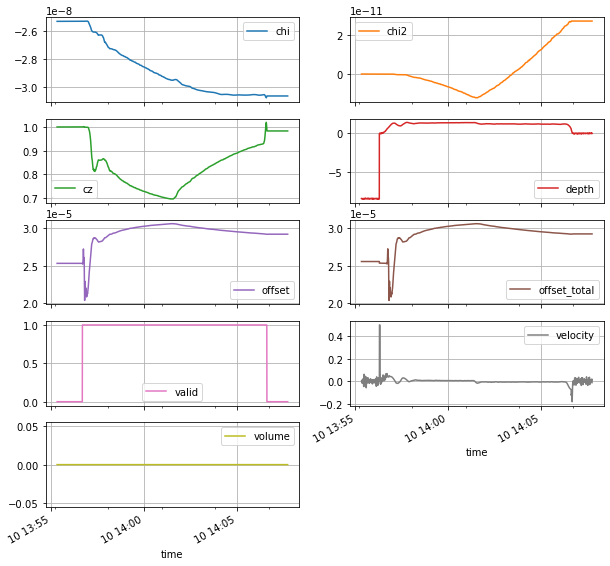

In [5]:
_ = kalman_state.plot(subplots=True, grid=True, layout=(5,2), figsize=(10,10))

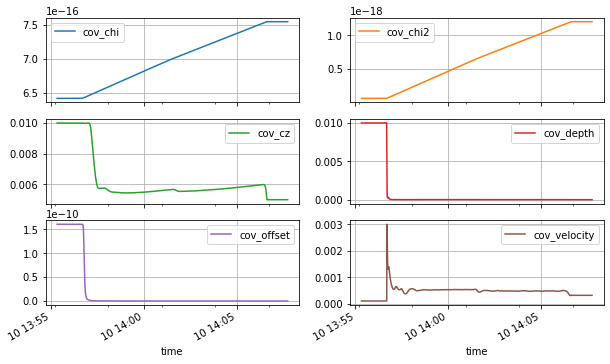

In [6]:
_ = kalman_cov.plot(subplots=True, grid=True, layout=(5,2), figsize=(10,10))

---
## look at regulation

In [7]:
cfg['physics']

{'diam_collerette': 0.35,
 'g': 9.81,
 'm': 13.5,
 'piston_diameter': 0.0195,
 'piston_max_value': 1415.0,
 'piston_ref_eq': 1000.0,
 'piston_speed_max_tick': 20.0,
 'rho': 1020.0,
 'screw_thread': 8.48e-05,
 'tick_per_turn': 1.0}

In [8]:
cfg['regulation']['depth_controller']

{'delta_position_lb': 0.0,
 'delta_position_ub': 0.0,
 'delta_velocity_lb': 0.0,
 'delta_velocity_ub': 0.0,
 'divider_frequency': 5.0,
 'frequency': 25.0,
 'hold_depth_enable': False,
 'hold_depth_value_enter': 0.05,
 'hold_depth_value_exit': 0.0,
 'hysteresis_piston': 0.6,
 'limit_depth_controller': 0.2,
 'root_regulation': -0.5,
 'speed_volume_sink': 2.0}

---

## instantiate float object

In [9]:
ph = cfg['physics']
f = fl.autonomous_float(model='Ifremer', m=ph['m'])
f.init_piston()

print('tick_to_volume = {:.2e}'.format(f.piston.vol_increment))
print('volume available = {:.2e}'.format(f.piston.vol_max-f.piston.vol_min))
print('balast volume = {:.2e}'.format(f.piston.vol_increment*619.25))

Piston max volume set from max displacement
tick_to_volume = 2.56e-08
volume available = 2.69e-05
balast volume = 1.59e-05


In [10]:

#fl.regulation._control_feedback2?

### cognac lib 
# self._B = self.c1/(2*self.Lv*(1+self.a))
#
# seabot:
#  const double Cf = M_PI*pow(diam_collerette/2.0, 2);
#  tick_to_volume = (screw_thread/tick_per_turn)*pow(piston_diameter/2.0, 2)*M_PI;
#  coeff_A = g*rho/m;
#  coeff_B = 0.5*rho*Cf/m;
Cf = np.pi*(ph['diam_collerette']/2.)**2
B = 0.5*ph['rho']*Cf/ph['m']
A = ph['g']*ph['rho']/ph['m']
f.Lv = f.c1/(2*B*(1+f.a))

# regulation
r = cfg['regulation']['depth_controller']
#limit_velocity = 0.1 # from xml
#approach_velocity = 1. # from xml
limit_velocity = bdata['mission']['limit_velocity'].median()
approach_velocity = bdata['mission']['approach_velocity'].median()
root_regulation = r['root_regulation']

#ctrl = {'mode': 'feedback', 'dt': 5., 'dz_nochattering': 0.,
#      'nu': 2*target_velocity*2./np.pi, 'tau': 20., 'delta': .1,
#      'continuous': False}
ctrl = {'mode': 'feedback',
        'dt': 1/r['frequency'],
        'tau': 1/abs(root_regulation),  # Set the root of feed-back regulation # s assesed by simulation
        'nu': limit_velocity*2./np.pi, # Set the limit speed : 3cm/s assesed by simulation
        'delta': approach_velocity, #length scale that defines the zone of influence around the target depth, assesed by simulation
        'gamma': f.gamma, #mechanical compressibility [1/dbar]
        'rho_cte': ph['rho'],
         }

f.init_control(ctrl, f.v, ctrl['dt'])
print(f)

#def compute_u_f(f, z, dz, d2z, z_t, gamma):
#    return fl._control_feedback2(f.ctrl.lbd1, f.ctrl.lbd2, 
#                                 f.ctrl.nu, f.ctrl.delta, 
#                                 z, dz, d2z, z_t, gamma,
#                                 f.ctrl.A, f.ctrl.B)

f.ctrl

Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 13.50 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 1.06e+09 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 9.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the piston
  vol_increment  = 2.56e-02 cm^3      

Control parameters: 
  mode = feedback 
  dt = 4.00e-02 
  dz_nochattering = 0.00e+00 
  tau = 2.00e+00 
  nu = 6.37e-02 
  delta = 1.00e+00 
  continuous = 1.00e+00 

In [11]:
print('Number of ticks for 1 cm^3  : {:.1f} / dl={:.1e} mm'
      .format(1e-6/f.piston.vol_increment, 1e-6/f.piston.vol_increment*f.piston.d_increment*1e3, ))
print('Velocity for a 5g (={:.1f} ticks) difference : {:.1f} cm/s'
      .format(5*1e-6/f.piston.vol_increment, 
              1e2*f.get_drag_velocity(5e-3))
     )

Number of ticks for 1 cm^3  : 39.1 / dl=3.3e+00 mm
Velocity for a 5g (=195.3 ticks) difference : 2.2 cm/s


In [12]:
dt = '500ms'
dt = '1s'

df = sb.resample_join(dt,
                   bdata['kalman'][['velocity', 'depth', 'offset', 'chi', 'chi2', 'cz']],
                   bdata['pistonState']['position'],
                   bdata['mission']['depth'].rename('set_point'),
                   bdata['mission'][['limit_velocity','approach_velocity']]
                  )

df

,velocity,depth,offset,chi,chi2,cz,position,set_point,limit_velocity,approach_velocity
time,,,,,,,,,,
2020-06-10 13:55:51,0.002859,-8.361800,0.000025,-2.532532e-08,0.000000e+00,1.000000,0.00,0.0,0.1,1.0
2020-06-10 13:55:52,-0.010620,-8.370187,0.000025,-2.532532e-08,0.000000e+00,1.000000,0.00,0.0,0.1,1.0
2020-06-10 13:55:53,0.004214,-8.356462,0.000025,-2.532532e-08,0.000000e+00,1.000000,0.00,0.0,0.1,1.0
2020-06-10 13:55:54,0.008770,-8.364087,0.000025,-2.532532e-08,0.000000e+00,1.000000,0.00,0.0,0.1,1.0
2020-06-10 13:55:55,-0.019825,-8.377811,0.000025,-2.532532e-08,0.000000e+00,1.000000,0.00,0.0,0.1,1.0
...,...,...,...,...,...,...,...,...,...,...
2020-06-10 14:07:39,0.006514,0.011894,0.000029,-3.062278e-08,2.696101e-11,0.983109,1.25,0.0,0.0,1.0
2020-06-10 14:07:40,0.001145,0.010370,0.000029,-3.062278e-08,2.696101e-11,0.983109,1.25,0.0,0.0,1.0
2020-06-10 14:07:41,-0.006098,-0.001830,0.000029,-3.062278e-08,2.696101e-11,0.983109,1.25,0.0,0.0,1.0


In [13]:
u = sb.compute_u(f, df, root_regulation, limit_velocity, approach_velocity)

In [14]:
df_u = sb.resample_join(dt, 
                     bdata['regulation']['u'].rename('u_bag'),
                     sum(u).rename('u_reconstructed'),
                     df['depth'],
                     *u
                    )
df_u = df_u[df_u['depth']>.1]

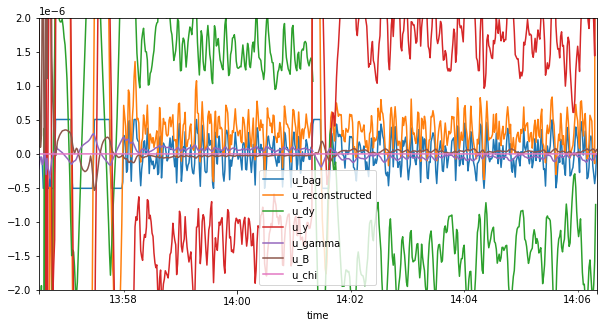

In [15]:
df_u.drop(columns='depth').plot(ylim=[-2e-6,2e-6], figsize=(10,5))

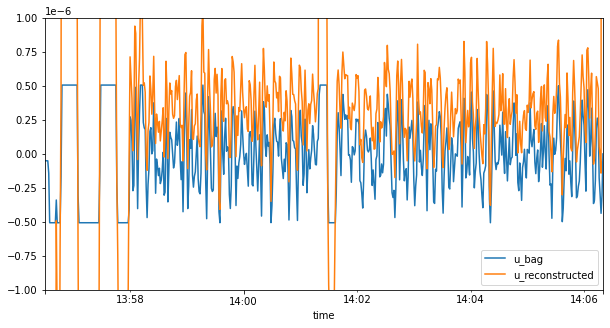

In [16]:
df_u[['u_bag', 'u_reconstructed']].plot(ylim=[-1e-6,1e-6], figsize=(10,5))

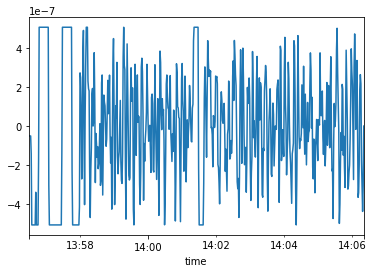

In [17]:
df_u['u_bag'].plot()

### detailed decomposition

In [18]:
U = sb.compute_u(f, df, root_regulation, limit_velocity, approach_velocity, decomposed=True)

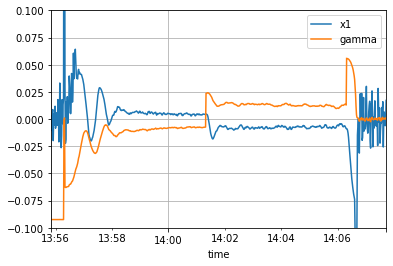

In [19]:
pd.concat(U['y'], axis=1).plot(grid=True, ylim=(-.1,.1))

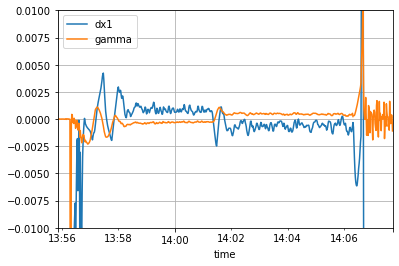

In [20]:
pd.concat(U['dy'], axis=1).plot(grid=True, ylim=(-.01,.01))

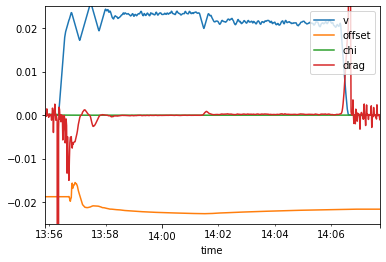

In [21]:
pd.concat(U['dx1'], axis=1).plot(ylim=(-.025,.025))

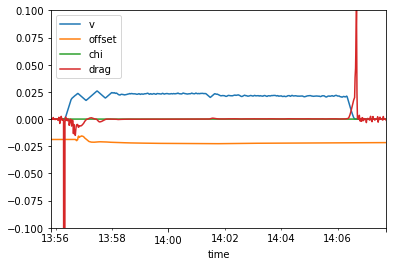

In [22]:
pd.concat(U['dx1'], axis=1).plot(ylim=(-.1,.1))

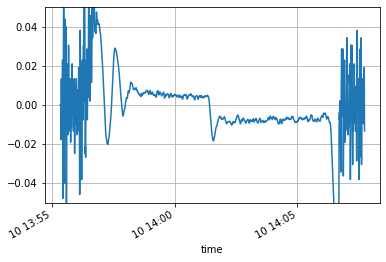

In [23]:
kalman_state['velocity'].plot(grid=True, ylim=[-.05,.05])

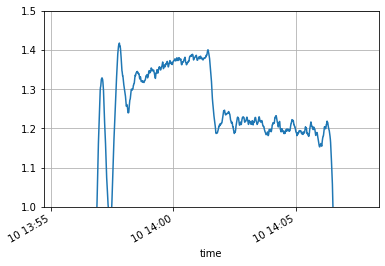

In [24]:
kalman_state['depth'].plot(grid=True, ylim=[1.,1.5])

In [25]:
bdata['regulation'].seconds.diff().median()

0.20000011399999096

In [26]:
# should do:
# - estimated_first_error_equilibrium_tick = balast piston position
# - piston_ref_eq larger value (name is not really appropriate ...)
# 
# check offset 
#
# éteindre chi: petit, sûrement pas pb


---

## stratification profile

In [27]:
p = np.arange(0,2,.1)
t = 15.*(p-p[-1])/(p[0]-p[-1]) - 16.*(p-p[0])/(p[0]-p[-1])
s = t*0.+30
w = fl.waterp(pressure=p, temperature=t, salinity=s, lon=6.,lat=40.) # 

Provided water profile at lon=6, lat=40

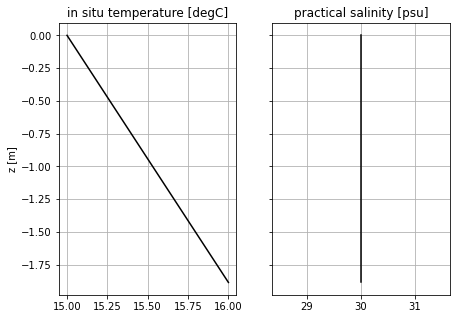

In [28]:
w

-444.0 g  were added to the float in order to be at equilibrium at 0 dbar 



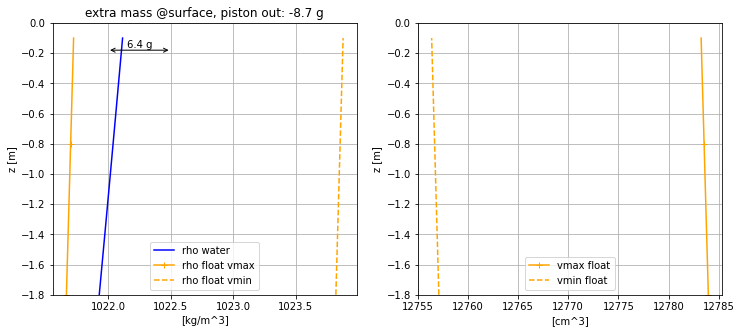

In [29]:
z=np.arange(-1.8,0.,.1)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

In [30]:
_z = [0., -1.8]
dm = (w.get_rho(0.)-w.get_rho(-1.8))*f.V
print('Equivalent mass difference between z={} and z={} because of water density only: {}g'
     .format(_z[0],_z[1], dm*1e3))

Equivalent mass difference between z=0.0 and z=-1.8 because of water density only: 2.511287559959642g


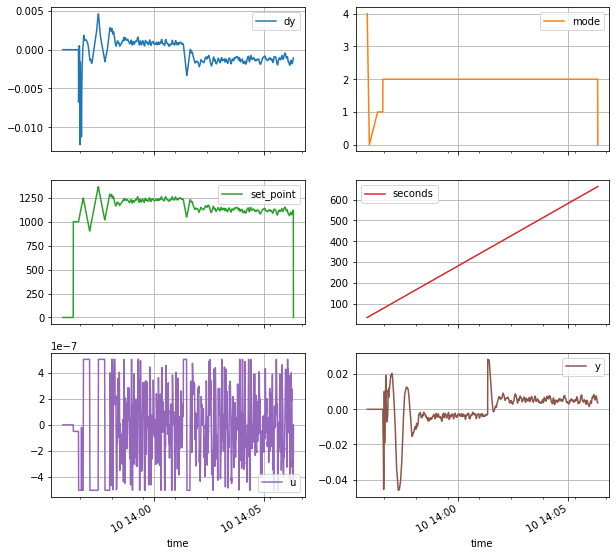

In [31]:
_ = bdata['regulation'].plot(subplots=True, grid=True, layout=(3,2),figsize=(10,10))

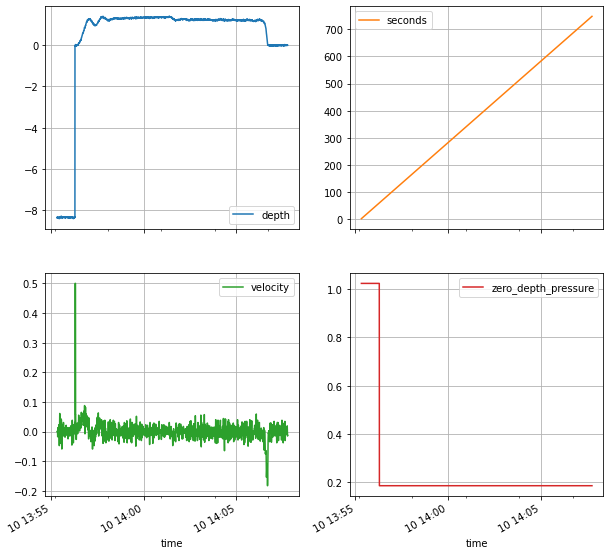

In [32]:
_ = bdata['depthFusion'].plot(subplots=True, grid=True, layout=(2,2), figsize=(10,10))

### extract stratification

Sampling rate: 0.20s


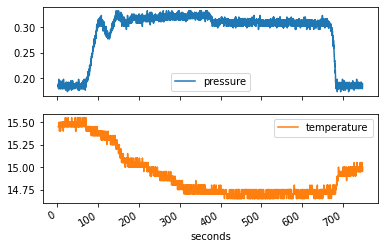

In [33]:
dt = bdata['sensorExt']['seconds'].diff()
print('Sampling rate: {:.2f}s'.format(dt[dt>0].mean()))
_ = bdata['sensorExt'][dt>0].plot(x='seconds', subplots=True)

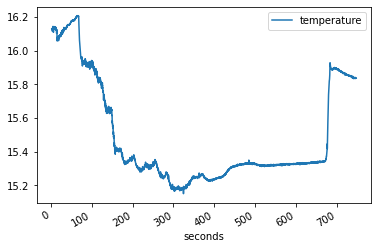

In [34]:
dv = abs(bdata['temperature']['temperature'].diff())
threshold = dv.quantile(.99)
_ = bdata['temperature'][dv<threshold].plot(x='seconds', subplots=True)

In [35]:
# merge pressure and temperature data

dv = abs(bdata['temperature']['temperature'].diff())
T = (bdata['temperature'][dv<threshold]['temperature']
     .resample('1s')
     .median()
    )

dt = bdata['sensorExt']['seconds'].diff()
D = (bdata['sensorExt'][dt>0]['pressure']
     .resample('1s')
     .median()
     .rename('depth')
     *1e5/(1000*9.81)
    )
D = D - D.min()

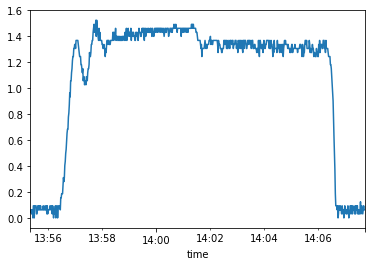

In [36]:
_ = D.plot()

In [37]:
df = pd.concat([T, D], axis=1)

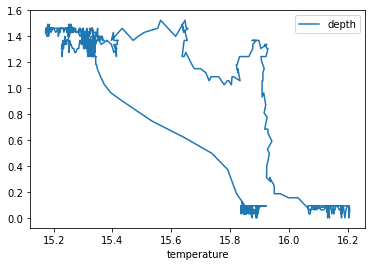

In [38]:
df.plot(x='temperature')

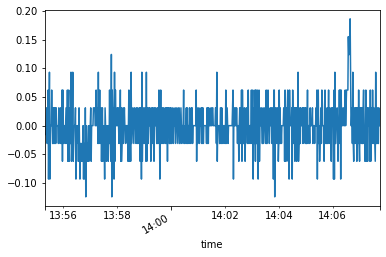

In [40]:
pr = sb.get_depth_profile(df)

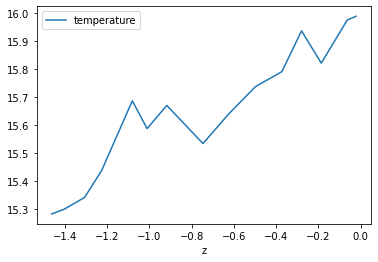

In [41]:
pr.plot()

---

### multiple deployments

In [2]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/'
#root_dir = root_dir+'bassin0_bags/'
root_dir = root_dir+'bassin1_bags/'
bags = sorted(glob(root_dir+'pd_*'))
cfgs = sb.find_logs(root_dir)
bags

['/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-18-07_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-35-39_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-55-40_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-04-14_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-15-25_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-28-29_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-41-36_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-48-45_0',
 '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-16-14-23_0',
 '/Users/aponte/Current_projects/cognac/tests/

In [5]:
# compare configurations
_c0 = None
for f, c in zip(bags, cfgs):
    print('-- {} --'.format(f.split('/')[-1]))
    _c1 = sb.load_config_from_log(c)
    if _c0:
        sb.compare_config(_c0, _c1)
    _c0 = _c1

-- pd_2020-06-18-14-18-07_0 --
-- pd_2020-06-18-14-35-39_0 --
-- pd_2020-06-18-14-55-40_0 --
-- pd_2020-06-18-15-04-14_0 --
-- pd_2020-06-18-15-15-25_0 --
driver->filter->iridium->kalman->mission->physics->regulation->safety :
 -  battery_limit  :  11.0
 +  battery_limit  :  9.0
-- pd_2020-06-18-15-28-29_0 --
-- pd_2020-06-18-15-41-36_0 --
driver->filter->iridium->kalman :
 -  gamma_alpha_offset  :  5.0
 +  gamma_alpha_offset  :  20.0
-- pd_2020-06-18-15-48-45_0 --
-- pd_2020-06-18-16-14-23_0 --
driver->filter->iridium->kalman->mission->physics->regulation->depth_controller :
 -  root_regulation  :  -0.5
 +  root_regulation  :  -0.1
-- pd_2020-06-18-16-18-45_0 --


In [88]:
bdata = sb.load_bag(bags[-3])

#for b, d in bdata.items():
#    print(b, list(d))

# load config file
#file = root_dir+'config_ifremer1.yaml'
#cfg = load_config(file)
#
#log_file = root_dir+'20200610_m10bis.log'
#cfg = sb.load_config_from_log(log_file)
#cfg

df = sb.resample_join('500ms',
                      bdata['depthFusion']['depth'],
                      bdata['pistonState']['position']
                     )

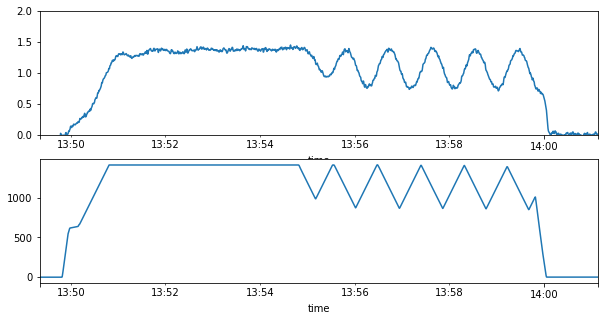

In [89]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
df['depth'].plot(ylim=(0,2), ax=ax[0])
df['position'].plot(ax=ax[1])

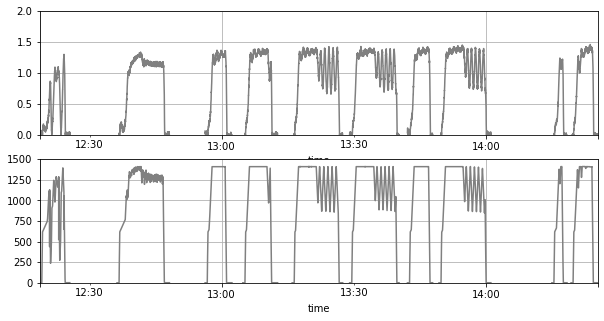

In [85]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

for f in bags:
    bdata = sb.load_bag(f)
    df = sb.resample_join('500ms',
                      bdata['depthFusion']['depth'],
                      bdata['pistonState']['position']
                     )
    df['depth'].plot(color='0.5',
                     ax=ax[0],
                     ylim=(0,2))
    df['position'].plot(color='0.5',
                        ax=ax[1],
                        ylim=(0,1500))
ax[0].grid()
ax[1].grid()

Text(0.5, 1.0, 'piston position')

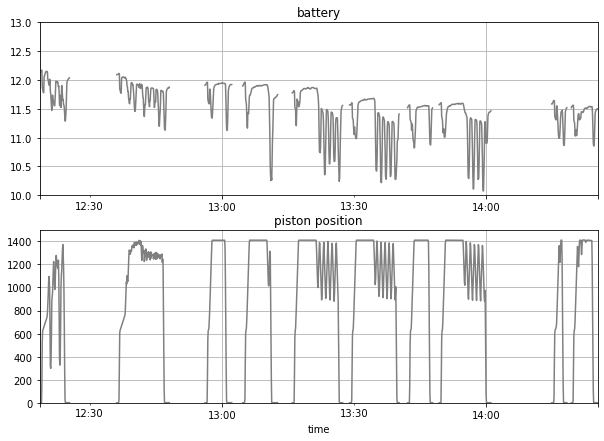

In [66]:
fig, ax = plt.subplots(2,1, figsize=(10,7))

for f in bags:
    bdata = sb.load_bag(f)
    df = sb.resample_join('5s',
                      bdata['depthFusion']['depth'],
                      bdata['pistonState']['position'],
                      bdata['batteryFusion']['b1'].rename('battery')
                     )
    df['battery'].plot(color='0.5',
                     ax=ax[0],
                     ylim=(10,13))
    df['position'].plot(color='0.5',
                        ax=ax[1],
                        ylim=(0,1500))
ax[0].grid()
ax[0].set_title('battery')
ax[0].set_xlabel('')
ax[1].grid()
ax[1].set_title('piston position')